# Notebook 018: Initial EDA for NOAA Boston Weather Data

This notebooks contains EDA and data cleansing for NOAA Boston weather data.

A resulting cleansed dataset is saved to the interim data directory.


In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/noaa'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/noaa')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_daily = os.path.join(READDIR_ROOT, 'noaa/boston-daily-summaries-20140101-20191107.csv')
readfile_local = os.path.join(READDIR_ROOT, 'noaa/boston-local-climatological-data-20140101-20191107.csv')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}'.format(
        readfile_daily, readfile_local, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/noaa/boston-daily-summaries-20140101-20191107.csv
	../data/raw/noaa/boston-local-climatological-data-20140101-20191107.csv
	../figures/noaa
	../data/interim/noaa


In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [4]:
# read in required data and related shapefiles
df_daily = pd.read_csv(readfile_daily)
df_local = pd.read_csv(readfile_local, dtype=str)

# convert data columns to datetime for easier manipulation
df_daily['DATE'] = pd.to_datetime(df_daily['DATE'])
df_local['DATE'] = pd.to_datetime(df_local['DATE'])

In [5]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 69 columns):
STATION                       2137 non-null object
NAME                          2137 non-null object
DATE                          2137 non-null datetime64[ns]
ACMH                          0 non-null float64
ACMH_ATTRIBUTES               0 non-null float64
ACSH                          0 non-null float64
ACSH_ATTRIBUTES               0 non-null float64
AWND                          2135 non-null float64
AWND_ATTRIBUTES               2135 non-null object
ELEVATION                     2137 non-null float64
ELEVATION_ATTRIBUTES          0 non-null float64
FRGT                          0 non-null float64
FRGT_ATTRIBUTES               0 non-null float64
LATITUDE                      2137 non-null float64
LATITUDE_ATTRIBUTES           0 non-null float64
LONGITUDE                     2137 non-null float64
LONGITUDE_ATTRIBUTES          0 non-null float64
PGTM                          70

In [6]:
df_local.info()

df_local.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81815 entries, 0 to 81814
Columns: 128 entries, STATION to WindEquipmentChangeDate
dtypes: datetime64[ns](1), object(127)
memory usage: 79.9+ MB


Index(['STATION', 'NAME', 'DATE', 'REPORT_TYPE', 'SOURCE', 'AWND',
       'BackupDirection', 'BackupDistance', 'BackupDistanceUnit',
       'BackupElements',
       ...
       'ShortDurationPrecipitationValue060',
       'ShortDurationPrecipitationValue080',
       'ShortDurationPrecipitationValue100',
       'ShortDurationPrecipitationValue120',
       'ShortDurationPrecipitationValue150',
       'ShortDurationPrecipitationValue180', 'Sunrise', 'Sunset', 'TStorms',
       'WindEquipmentChangeDate'],
      dtype='object', length=128)

In [7]:
df_daily['DATE'].head()

0   2014-01-01
1   2014-01-02
2   2014-01-03
3   2014-01-04
4   2014-01-05
Name: DATE, dtype: datetime64[ns]

In [8]:
df_local['REPORT_TYPE'].value_counts()

FM-15    51231
FM-12    16476
FM-16    11850
SOD       2136
SOM         69
SY-MT       53
Name: REPORT_TYPE, dtype: int64

In [9]:
# subset local climatological data for daily summaries only
df_sod = df_local.loc[df_local['REPORT_TYPE']=='SOD  ']

df_sod.shape

(2136, 128)

In [10]:
print(
    'The daily summary records contained in the local climatological range between:\n\n'\
    '\t{}\n\t{}'.format(df_sod['DATE'].min(), df_sod['DATE'].max())
)

The daily summary records contained in the local climatological range between:

	2014-01-01 23:59:00
	2019-11-07 23:59:00


In [11]:
# subset daily summaries to include only days that match crime records for analysis
df_sod = df_sod.loc[
    (df_sod['DATE']>='2016-01-01') & (df_sod['DATE']<'2019-09-01')
]

print(
    'The daily summary records subsetted by date now range between:\n\n'\
    '\t{}\n\t{}\n\n'.format(df_sod['DATE'].min(), df_sod['DATE'].max())
)
print('And the resulting dataframe is of the shape: {}'.format(df_sod.shape))


The daily summary records subsetted by date now range between:

	2016-01-01 23:59:00
	2019-08-31 23:59:00


And the resulting dataframe is of the shape: (1339, 128)


In [12]:
# Drop all columns with no recorded values (this removes non-daily measures)
df_sod = df_sod.dropna(axis=1, how='all')

# convert 'T' trace values indicator to 0 for numeric conversion
df_sod['DailyPrecipitation'] = df_sod['DailyPrecipitation'].copy().map({'T':0}).fillna(df_sod['DailyPrecipitation'])
df_sod['DailySnowfall'] = df_sod['DailySnowfall'].copy().map({'T':0}).fillna(df_sod['DailySnowfall'])

# convert any number-like columns to numeric for EDA
convert_cols = df_sod.columns[3:]

for col in convert_cols:
    df_sod[col] = pd.to_numeric(df_sod[col], errors='ignore')

print('The resulting dataframe summary once all non-daily features are dropped is:\n')
df_sod.info()

The resulting dataframe summary once all non-daily features are dropped is:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1339 entries, 27868 to 79307
Data columns (total 42 columns):
STATION                                       1339 non-null object
NAME                                          1339 non-null object
DATE                                          1339 non-null datetime64[ns]
REPORT_TYPE                                   1339 non-null object
SOURCE                                        1339 non-null int64
BackupDirection                               1339 non-null object
BackupDistance                                1339 non-null float64
BackupDistanceUnit                            1339 non-null object
BackupElements                                1339 non-null object
BackupElevation                               1339 non-null float64
BackupEquipment                               1339 non-null object
BackupLatitude                                1339 non-null float

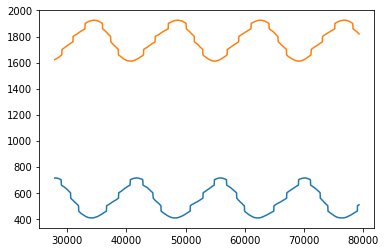

In [13]:
plt.plot(df_sod['Sunrise'])
plt.plot(df_sod['Sunset'])

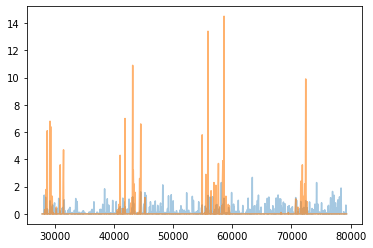

In [14]:
plt.plot(df_sod['DailyPrecipitation'], alpha=0.4)
plt.plot(df_sod['DailySnowfall'], alpha=0.6)

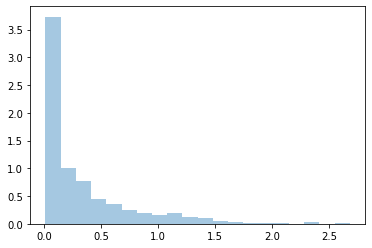

500


In [15]:
plt.hist(df_sod.loc[df_sod['DailyPrecipitation']>0]['DailyPrecipitation'], density=True, bins=20, alpha=0.4)
plt.show();

print(len(df_sod.loc[df_sod['DailyPrecipitation']>0]['DailyPrecipitation']))

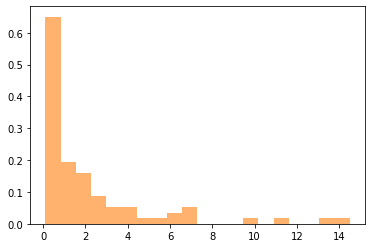

79


In [16]:
plt.hist(df_sod.loc[df_sod['DailySnowfall']>0]['DailySnowfall'], color='tab:orange', density=True, bins=20, alpha=0.6)
plt.show();

print(len(df_sod.loc[df_sod['DailySnowfall']>0]['DailySnowfall']))

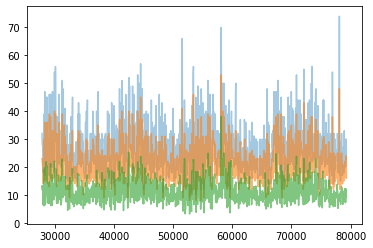

In [17]:
plt.plot(df_sod['DailyPeakWindSpeed'], alpha=0.4)
plt.plot(df_sod['DailySustainedWindSpeed'], alpha=0.6)
plt.plot(df_sod['DailyAverageWindSpeed'], alpha=0.6)

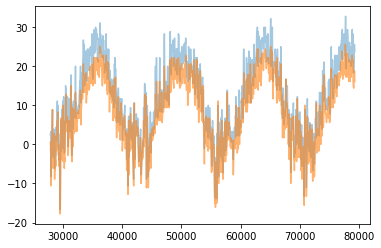

In [18]:
plt.plot(df_sod['DailyAverageDryBulbTemperature'], alpha=0.4)
plt.plot(df_sod['DailyAverageWetBulbTemperature'], alpha=0.6)

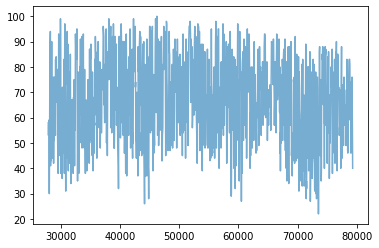

In [19]:
plt.plot(df_sod['DailyAverageRelativeHumidity'], alpha=0.6)

In [20]:
df_sod['DailyWeather'].value_counts(dropna=False)

NaN                       679
RA BR                     158
RA                        119
RA DZ BR                   56
SN BR                      31
RA FG BR                   30
TS RA BR                   28
BR                         27
FG BR                      24
SN                         23
TS RA                      20
RA SN BR                   14
RA DZ FG BR                10
SN FZFG BR FG               8
HZ                          6
TS RA DZ BR                 5
RA SN                       5
TS                          5
RA BR HZ                    4
SN FG BR                    4
RA SN FG BR                 4
DZ BR                       4
RA SN FG FZFG BR            3
RA DZ SN BR                 3
DZ                          3
RA SN PL BR                 3
BR HZ                       3
TS RA FG BR                 3
FG                          3
RA DZ SN FG BR              2
                         ... 
TS RA FG                    1
RA SN BR PL                 1
RA SN PL F

In [21]:
df_sod.columns

Index(['STATION', 'NAME', 'DATE', 'REPORT_TYPE', 'SOURCE', 'BackupDirection',
       'BackupDistance', 'BackupDistanceUnit', 'BackupElements',
       'BackupElevation', 'BackupEquipment', 'BackupLatitude',
       'BackupLongitude', 'BackupName', 'DailyAverageDewPointTemperature',
       'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity',
       'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure',
       'DailyAverageWetBulbTemperature', 'DailyAverageWindSpeed',
       'DailyCoolingDegreeDays', 'DailyDepartureFromNormalAverageTemperature',
       'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature',
       'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection',
       'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySnowfall',
       'DailySustainedWindDirection', 'DailySustainedWindSpeed',
       'DailyWeather', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'REM',
       'REPORT_TYPE.1', 'SOURCE.1', 'Sunrise', 'Sunset',
       'WindEquipmentChangeDate'],
    

In [22]:
column_dict = {
    'DATE': 'date',
    'DailyWeather': 'weathercodes',
    'Sunrise': 'sunrise',
    'Sunset': 'sunset',
    'DailyAverageDryBulbTemperature': 'tempavg',
    'DailyMaximumDryBulbTemperature': 'tempmax',
    'DailyMinimumDryBulbTemperature': 'tempmin',
    'DailyAverageRelativeHumidity': 'humavg',
    'DailyAverageWindSpeed': 'windavg',
    'DailySustainedWindSpeed': 'windsustain',
    'DailyPeakWindSpeed': 'windmax',
    'DailyPrecipitation': 'precip',
    'DailySnowfall': 'snowfall',
}

In [23]:
df_noaa = df_sod[column_dict.keys()].rename(columns=column_dict)

df_noaa['date'] = df_noaa['date'].astype(str).str[:10]

In [24]:
df_noaa.info()

df_noaa.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1339 entries, 27868 to 79307
Data columns (total 13 columns):
date            1339 non-null object
weathercodes    660 non-null object
sunrise         1339 non-null int64
sunset          1339 non-null int64
tempavg         1339 non-null float64
tempmax         1339 non-null float64
tempmin         1339 non-null float64
humavg          1338 non-null float64
windavg         1339 non-null float64
windsustain     1339 non-null int64
windmax         1339 non-null int64
precip          1339 non-null float64
snowfall        1339 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 146.5+ KB


,date,weathercodes,sunrise,sunset,tempavg,tempmax,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall
27868,2016-01-01,NaN,713,1622,2.8,5.0,0.6,58.0,12.7,23,32,0.0,0.0
27901,2016-01-02,NaN,714,1623,2.2,4.4,-0.6,53.0,13.3,22,28,0.0,0.0
27934,2016-01-03,NaN,714,1624,3.3,6.7,-0.6,57.0,11.7,21,28,0.0,0.0
27970,2016-01-04,SN,714,1625,-3.9,2.2,-10.0,59.0,12.4,21,28,0.0,0.0
28005,2016-01-05,NaN,714,1626,-8.3,-3.3,-13.3,41.0,10.0,18,23,0.0,0.0


/home/sedelmeyer/Code/cs109a-predicting-crime/env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sedelmeyer/Code/cs109a-predicting-crime/env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


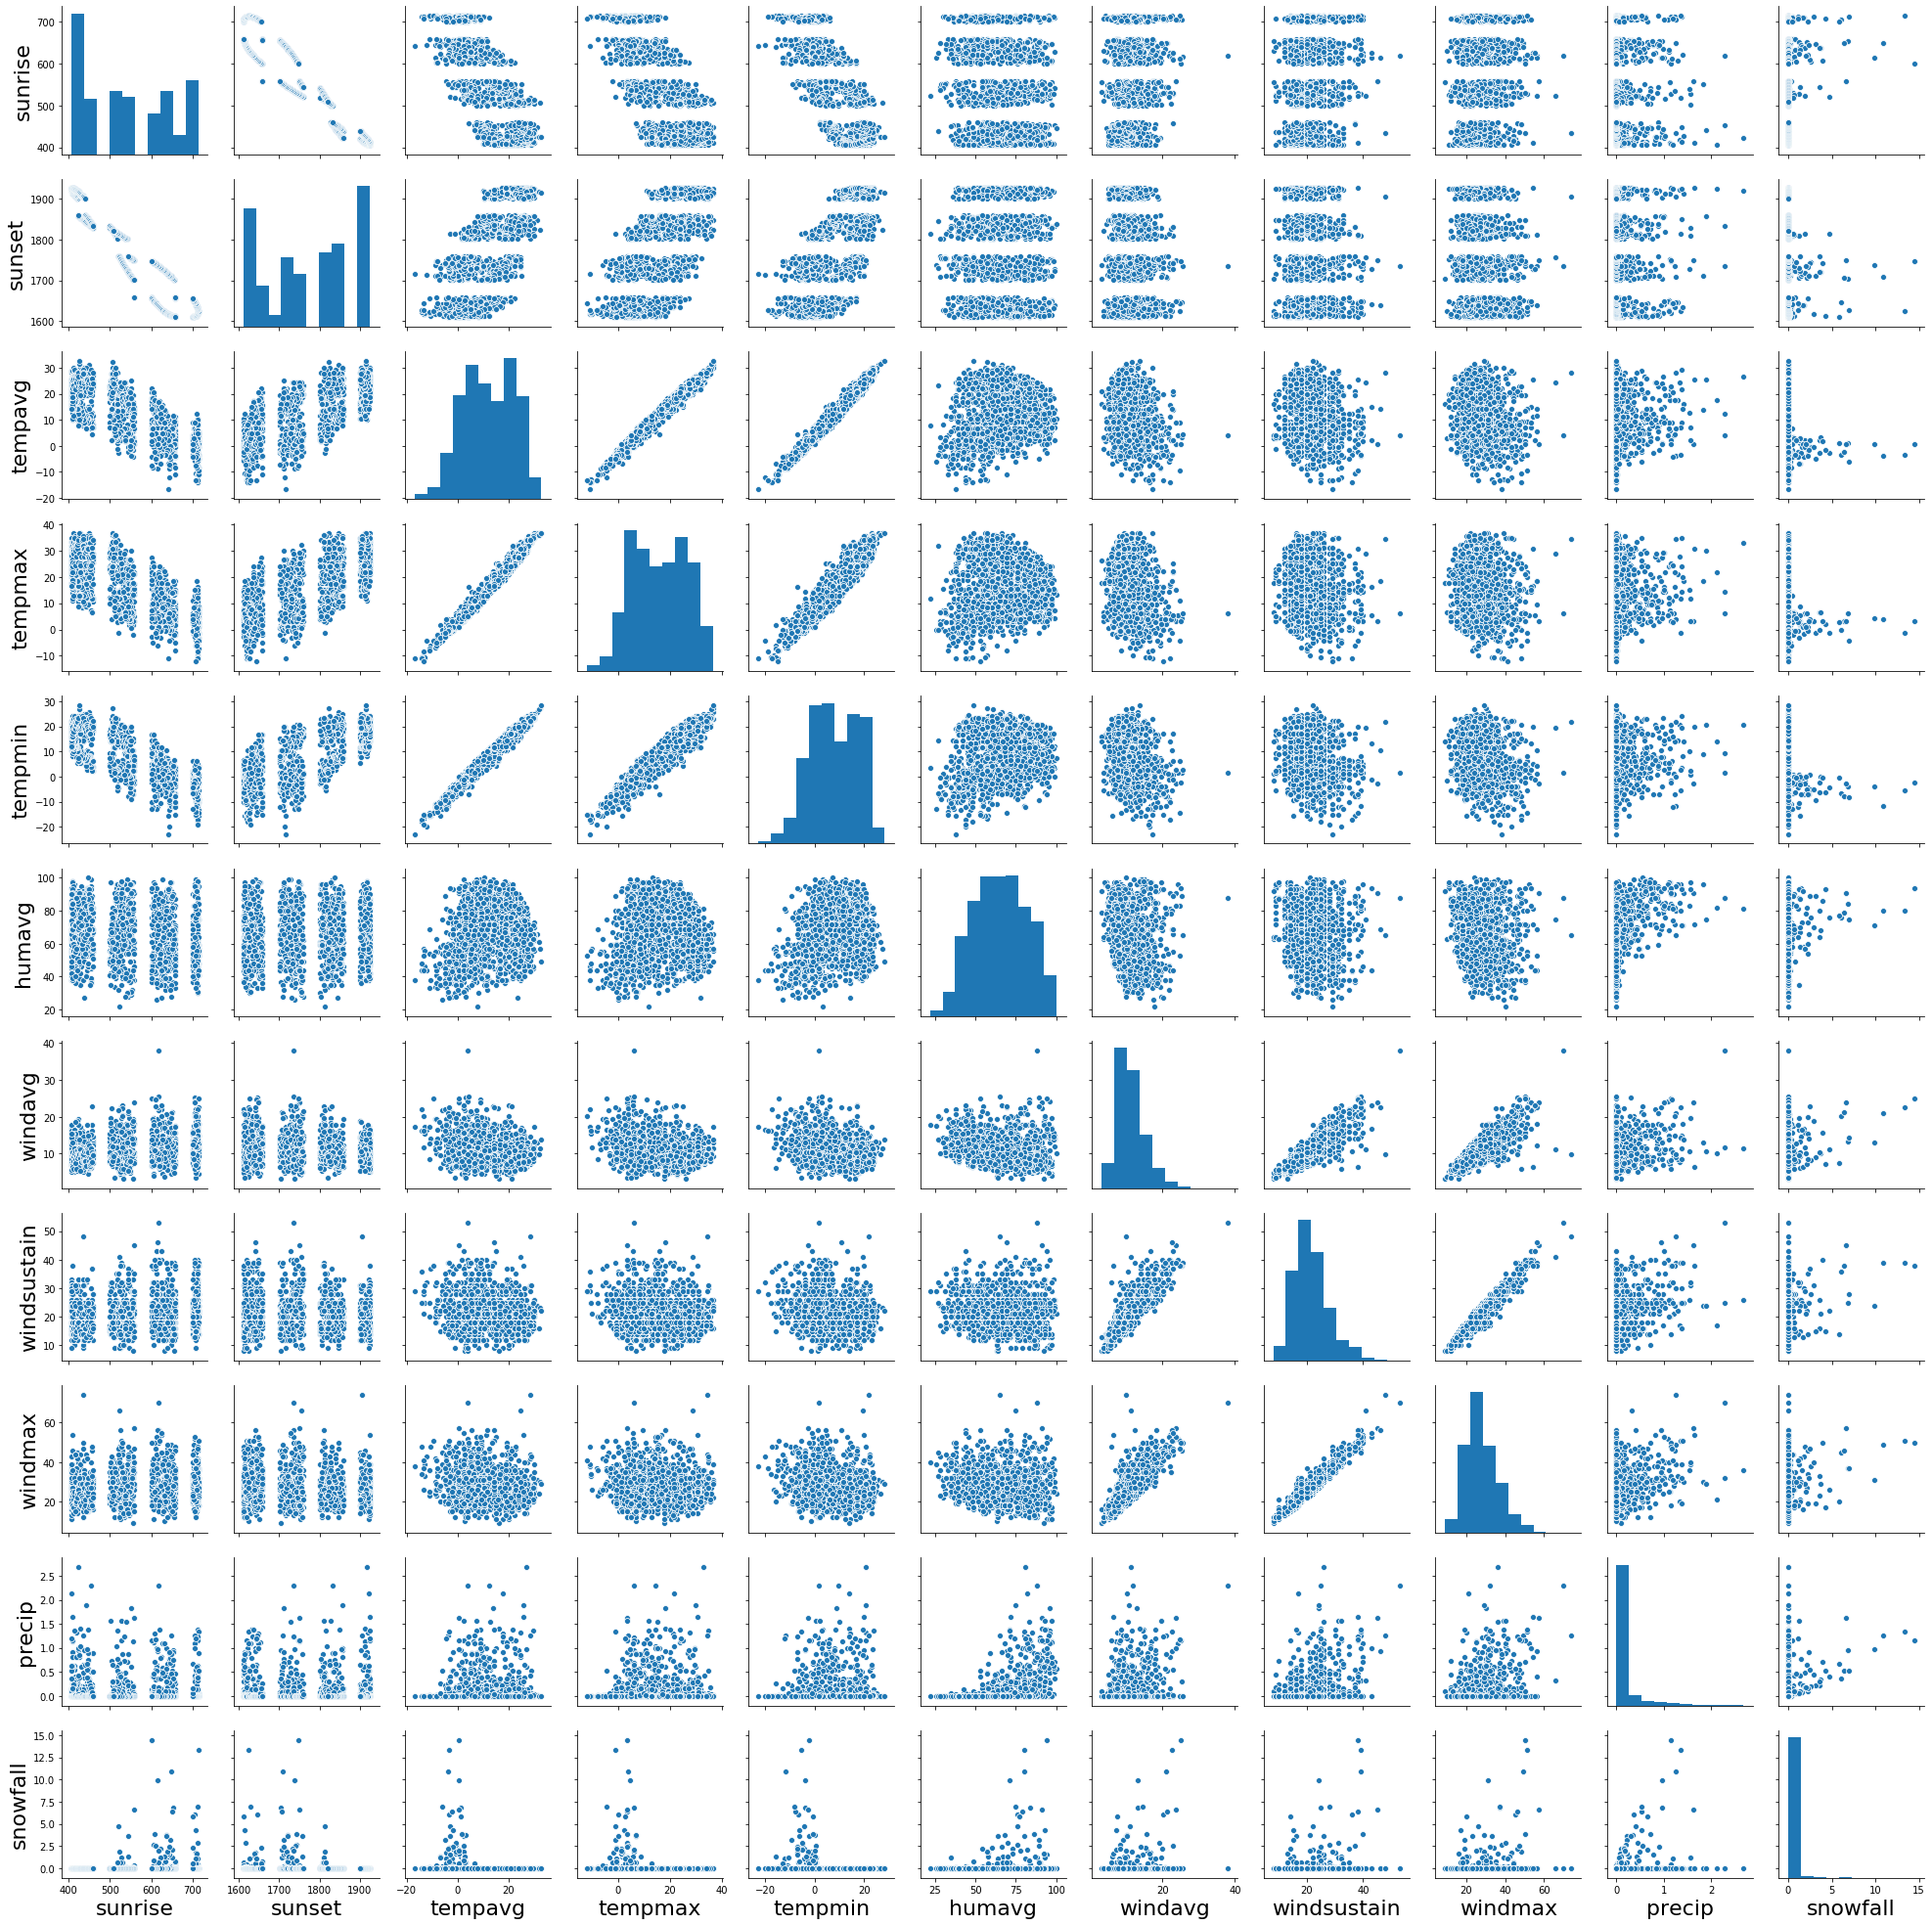

CPU times: user 19.5 s, sys: 53.7 ms, total: 19.6 s
Wall time: 19.6 s


In [25]:
%%time
sns.set_context(font_scale=20, rc={"axes.labelsize":22})
sns.pairplot(df_noaa.iloc[:,2:])
plt.show();

## Save cleansed data to NOAA interim data directory

In [26]:
df_noaa.to_csv(os.path.join(FEATURES_ROOT, 'boston-daily-weather-20140101-20190831.csv'), index=False)